<a href="https://colab.research.google.com/github/Renjian-buchai/buildingBloCS/blob/main/PillDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV Manipilation


In [ ]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('your_file.csv')

# Retain only the "filename" and "region_shape_attributes" columns
df = df[['filename', 'region_shape_attributes']]

# Save the modified DataFrame to a new CSV file
df.to_csv('new_file.csv', index=False)

In [ ]:
import json

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('your_file.csv')

# Extract x_min, y_min, x_max, and y_max from region_shape_attributes
df['region_shape_attributes'] = df['region_shape_attributes'].apply(lambda x: json.loads(x))
df['x_min'] = df['region_shape_attributes'].apply(lambda x: x['x'])
df['y_min'] = df['region_shape_attributes'].apply(lambda x: x['y'])
df['x_max'] = df['region_shape_attributes'].apply(lambda x: x['x'] + x['width'])
df['y_max'] = df['region_shape_attributes'].apply(lambda x: x['y'] + x['height'])

# Remove the region_shape_attributes column
df = df.drop(columns=['region_shape_attributes'])

# Save the modified DataFrame to a new CSV file
df.to_csv('new_file.csv', index=False)

In [11]:
import csv

# Read the CSV file
with open('annotations.csv', 'r') as file:
    # Read the CSV content
    csv_data = list(csv.reader(file))

# Remove the first row
csv_data = csv_data[1:]

# Write the updated content to a new file
with open('annotations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)


In [13]:
import pandas as pd

df = pd.read_csv('annotations.csv')
display(df)

,00000976_7.jpg,135,107,204,177
0,00000921_7.jpg,215,137,250,208
1,00000921_7.jpg,198,150,244,198
2,00000864_7.jpg,111,136,173,173
3,00000850_7.jpg,69,121,105,173
4,00000850_7.jpg,144,137,167,181
...,...,...,...,...,...
200,00000394.jpg,39,80,82,126
201,00000394.jpg,135,97,167,128
202,00000273.jpg,162,122,206,180
203,00000273.jpg,96,173,116,196


Imports

In [5]:
# import the necessary packages
# from pyimagesearch import config

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
import mimetypes
import argparse
import imutils
from google.colab.patches import cv2_imshow

from keras.preprocessing.image import ImageDataGenerator

In [1]:
!unzip testing_V2.zip

Archive:  testing.zip
   creating: Test/
 extracting: Test/00000394_5.jpg     
 extracting: Test/00000399_4.jpg     
 extracting: Test/00000729_3.jpg     
 extracting: Test/00000735_4.jpg     
 extracting: Test/00000976_4.jpg     
 extracting: Test/00000600_2.jpg     
 extracting: Test/00000850_3.jpg     
 extracting: Test/00000735_3.jpg     
 extracting: Test/00000399_3.jpg     
 extracting: Test/00000891.jpg       
 extracting: Test/00000976_1.jpg     
 extracting: Test/00000399_5.jpg     
 extracting: Test/00000399_7.jpg     
 extracting: Test/00000735_8.jpg     
 extracting: Test/00000850.jpg       
 extracting: Test/00000864_4.jpg     
 extracting: Test/00000864_8.jpg     
 extracting: Test/00000399_6.jpg     
 extracting: Test/00000976.jpg       
 extracting: Test/00000864_7.jpg     
 extracting: Test/00000976_6.jpg     
 extracting: Test/00000735_6.jpg     
 extracting: Test/00000729_6.jpg     
 extracting: Test/00000735_5.jpg     
 extracting: Test/00000921_7.jpg     
 extracti

Set some constants

In [70]:
ANNOTS_PATH = "/content/Test/annotations.csv"
IMAGES_PATH = "/content/Test"

TEST_FILENAMES = "/content/output/test_images.txt"
PLOT_PATH = "/content/output/plot.png"
MODEL_PATH = "/content/output/detector.h5"

INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 2

In [71]:
rows = open(ANNOTS_PATH).read().strip().split("\n")


data = []
targets = []
filenames = []

CSV reading and image loading

In [72]:
for row in rows:
	# break the row into the filename and bounding box coordinates
  row = row.split(",")
  (filename, startX, startY, endX, endY) = row
  imagePath = os.path.sep.join([IMAGES_PATH, filename])
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  # scale the bounding box coordinates relative to the spatial
  # dimensions of the input image
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
    # load the image and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  # update our list of data, targets, and filenames
  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

Partion Dataset

In [73]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.90,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()
print(len(testFilenames))

[INFO] saving testing filenames...
186


VGG finetuning

In [74]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Serialise and plot training history

[INFO] saving object detector model...


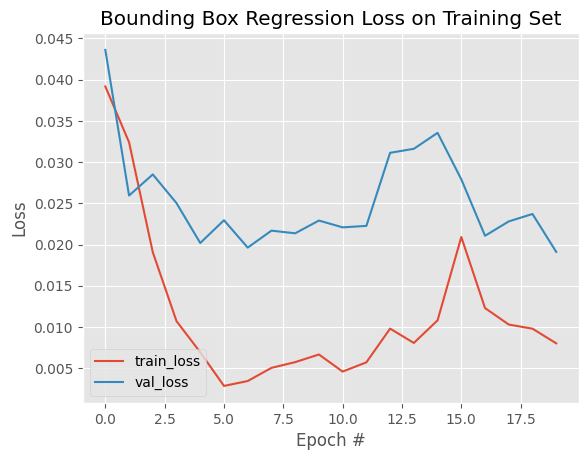

In [75]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

Implementation

In [13]:
model = load_model(MODEL_PATH)

1/1 [==============================] - 0s 72ms/step


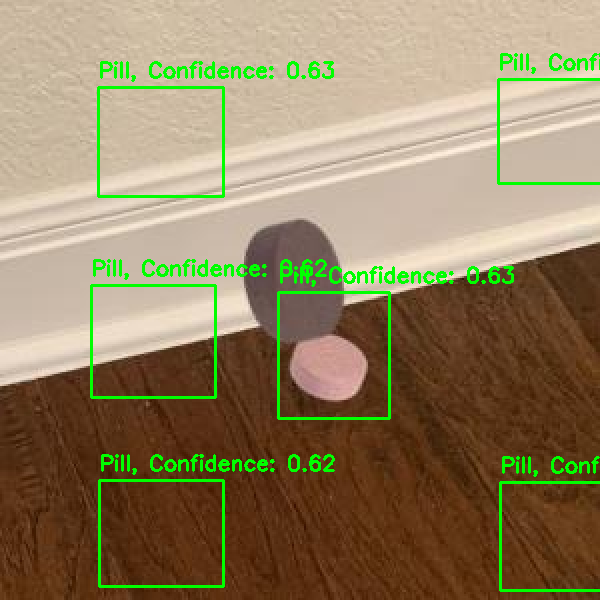

In [65]:
# import cv2
# from keras.preprocessing.image import load_img, img_to_array
# import numpy as np
# import imutils

# Define the number of grid divisions
rows = 3
cols = 3

# Load and preprocess the image
image = cv2.imread("/content/00000987.jpg")
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Calculate the ROI dimensions
roi_height = h // rows
roi_width = w // cols

# Iterate over the grid ROIs
for r in range(rows):
    for c in range(cols):
        # Calculate the ROI coordinates
        startX = c * roi_width
        startY = r * roi_height
        endX = startX + roi_width
        endY = startY + roi_height

        # Extract the ROI from the image
        roi = image[startY:endY, startX:endX]

        # Preprocess the ROI
        preprocessed_roi = cv2.resize(roi, (224, 224))
        preprocessed_roi = img_to_array(preprocessed_roi) / 255.0
        preprocessed_roi = np.expand_dims(preprocessed_roi, axis=0)

        # Make predictions for the ROI
        preds = model.predict(preprocessed_roi)

        # Iterate over the predictions
        for pred in preds:
            # Get the confidence level from the prediction
            confidence = np.max(pred)

            # Display the bounding box and label only if the confidence is above 0.4
            if confidence > 0.6:
                # Scale the predicted bounding box coordinates based on the ROI dimensions
                roi_startX = int(pred[0] * roi_width)
                roi_startY = int(pred[1] * roi_height)
                roi_endX = int(pred[2] * roi_width)
                roi_endY = int(pred[3] * roi_height)

                # Adjust the ROI coordinates to the image coordinates
                startX += roi_startX
                startY += roi_startY
                endX = startX + roi_endX
                endY = startY + roi_endY

                # Draw the predicted bounding box on the image
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

                # Display the confidence level as text
                text = f"Pill, Confidence: {confidence:.2f}"
                cv2.putText(image, text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Show the output image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()







In [30]:
!pip install ipywebrtc

import cv2
import numpy as np
from ipywebrtc import CameraStream, ImageRecorder

# Function to draw a grid on the image
def draw_grid(image, rows, cols, color=(0, 255, 0), thickness=1):
    height, width = image.shape[:2]
    cell_width = width // cols
    cell_height = height // rows

    # Draw vertical lines
    for c in range(1, cols):
        x = c * cell_width
        cv2.line(image, (x, 0), (x, height), color, thickness)

    # Draw horizontal lines
    for r in range(1, rows):
        y = r * cell_height
        cv2.line(image, (0, y), (width, y), color, thickness)

# Create a camera stream object
camera = CameraStream.facing_user(audio=False, video=True)

# Create an image recorder object
recorder = ImageRecorder(stream=camera)

# Display the camera feed and capture images
display(recorder)

# Function to process captured images
def process_image(image):
    # Convert image to numpy array
    frame = np.array(image.value, dtype=np.uint8)

    # Convert image to BGR format
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Draw a grid on the frame
    draw_grid(frame_bgr, rows=3, cols=3)

    # Display the processed frame
    cv2.imshow("Camera with Grid", frame_bgr)

# Register the process_image function as a callback for captured images
recorder.observe(process_image, names='value')

# Start the camera stream
camera.start()

# Keep running until the "Stop" button is clicked
while not recorder.closed:
    # Check for key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
camera.stop()
cv2.destroyAllWindows()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'audio': False, 'video': {'facingMode':…

AttributeError: ignored

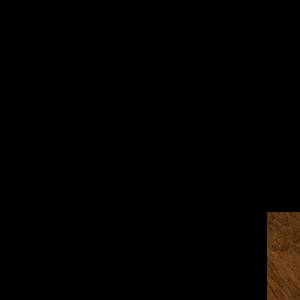

In [31]:
import cv2

# Read the image
image = cv2.imread('/content/00000987.jpg')

# Define the coordinates of the bounding box (top-left and bottom-right corners)
x1, y1 = startX,  startY  # Top-left corner
x2, y2 = endX, endY  # Bottom-right corner

# Create a mask image
mask = np.zeros_like(image)

# Set the pixels within the bounding box region to white (255)
mask[y1:y2, x1:x2] = 255

# Apply the mask to the original image using bitwise AND
result = cv2.bitwise_and(image, mask)

# Display the resulting image
cv2_imshow(result)